In [ ]:
!pip install matplotlib numpy seaborn datasets scikit-learn tqdm xicorpy scipy

In [1]:
import json
import os
import pickle
from collections import defaultdict
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
from datasets import load_dataset
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm

sns.set()
sns.set_theme(style='darkgrid')
sns.set_palette('colorblind')
sns.set_context('talk')
%matplotlib inline

/home/alvin/lib/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pile = load_dataset('usvsnsp/pile-semantic-memorization-filter-results')
memorized = load_dataset('usvsnsp/memories-semantic-memorization-filter-results')

/home/alvin/lib/miniconda3/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [3]:
pile.keys()

dict_keys(['pile.deduped.1.4b', 'pile.deduped.12b', 'pile.deduped.160m', 'pile.deduped.1b', 'pile.deduped.2.8b', 'pile.deduped.410m', 'pile.deduped.6.9b', 'pile.deduped.70m', 'pile.duped.1.4b', 'pile.duped.12b', 'pile.duped.160m', 'pile.duped.1b', 'pile.duped.2.8b', 'pile.duped.410m', 'pile.duped.6.9b', 'pile.duped.70m'])

In [4]:
memorized.keys()

dict_keys(['memories.deduped.1.4b', 'memories.deduped.12b', 'memories.deduped.160m', 'memories.deduped.1b', 'memories.deduped.2.8b', 'memories.deduped.410m', 'memories.deduped.6.9b', 'memories.deduped.70m', 'memories.duped.1.4b', 'memories.duped.12b', 'memories.duped.160m', 'memories.duped.1b', 'memories.duped.2.8b', 'memories.duped.410m', 'memories.duped.6.9b', 'memories.duped.70m'])

## Data Parameters Setup

In [5]:
model_sizes = [
    '70m',
    '160m',
    '410m',
    '1b',
    '1.4b',
    '2.8b',
    '6.9b',
    '12b'
]
data_schemes = ['deduped']
continuous_feature_columns = [
    'max_frequency',
    'avg_frequency',
    'min_frequency',
    'median_frequency',
    'p25_frequency',
    'p75_frequency',
    'prompt_perplexity',
    'generation_perplexity',
    'sequence_perplexity',
    'templating_frequency_0.9',
    'sequence_duplicates',
    # TODO: change -1 to 0
    'num_repeating',
]
categorical_feature_columns = [
    'is_incrementing',
]
all_feature_columns = continuous_feature_columns + categorical_feature_columns
feature_name_mapping = {
    'max_frequency': 'max_token_frequency',
    'avg_frequency': 'mean_token_frequency',
    'min_frequency': 'min_token_frequency',
    'median_frequency': 'median_token_frequency',
    'p25_frequency': 'p25_token_frequency',
    'p75_frequency': 'p75_token_frequency',
    'templating_frequency_0.9': 'templating_frequency@sim>0.9',
    'sequence_duplicates': 'num_sequence_duplicates',
}
renamed_feature_columns = [feature_name_mapping.get(n, n) for n in all_feature_columns]

In [6]:
def get_taxonomy(row):
    if row.memorization_score != 1.0:
        return 'not_memorized'
    if row.sequence_duplicates >= 200:
        return 'recitation'
    if row.is_incrementing or row.num_repeating > 0:
        return 'reconstruction'

    return 'recollection'

taxonomies = ['recitation', 'reconstruction', 'recollection']

## Logistic Regression (Baseline + Taxonomical) Model Training

In [7]:
# Data Hyper-parameters
seed = 2023_09_22
validation_split_percentage = 0.2

# Model Hyper-parameters
max_model_iterations = 1000
fit_intercept = True
reg_name = 'l2'
# Inverse of regularization strength; smaller values specify stronger regularization.
# Reference https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
reg_strength = 1.0

def train_lr_model(features, labels):
    prob_negatives = labels.value_counts().iloc[0] / len(labels)
    prob_positives = 1 - prob_negatives
    print(f'Memorized: {prob_positives * 100:.4f}% | Non-memorized: {prob_negatives * 100:.4f}%')
    
    # Split the dataset into 80% training and 20% validation
    X_train, X_val, Y_train, Y_val = train_test_split(
        features,
        labels,
        test_size=validation_split_percentage,
        random_state=seed,
    )

    # Train the model on the training data
    model = LogisticRegression(
        fit_intercept=fit_intercept,
        random_state=seed,
        max_iter=max_model_iterations,
        penalty=reg_name,
        C=reg_strength,
    )
    model.fit(X_train, Y_train)

    # Predict on the validation data
    Y_hat_val = model.predict_proba(X_val)[:, 1]

    # Calculate classification metrics
    roc_auc = roc_auc_score(Y_val, Y_hat_val)
    pr_auc = average_precision_score(Y_val, Y_hat_val)
    print(f'ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4}')
    print(f'Model Weights: {model.coef_[0]}')
    print('=' * 30)
    print()

    return (model, roc_auc, pr_auc)

In [8]:
lr_model_outputs = []

for scheme in data_schemes:
    for model_size in model_sizes:
        pile_df = pile[f'pile.{scheme}.{model_size}'].to_pandas()

        # Remove invalid rows where perplexities < 0 or perplexities = inf
        filtered_pile_df = pile_df[
            (pile_df.prompt_perplexity != -1) &
            (pile_df.generation_perplexity != -1) &
            (pile_df.sequence_perplexity != -1) &
            (pile_df.prompt_perplexity != np.inf) &
            (pile_df.generation_perplexity != np.inf) &
            (pile_df.sequence_perplexity != np.inf)
        ].reset_index(drop=True)
        # Replace -1 in num_repeating for continuous feature scaling
        filtered_pile_df['num_repeating'] = filtered_pile_df.num_repeating.replace({-1: 0})
        filtered_pile_df['taxonomy'] = filtered_pile_df.apply(get_taxonomy, axis=1)

        # Scale the continuous features to be zero-mean and unit-variance
        feature_scaler = StandardScaler().fit(filtered_pile_df[continuous_feature_columns])
        scaled_continuous_features = feature_scaler.transform(filtered_pile_df[continuous_feature_columns])
        categorical_features = filtered_pile_df[categorical_feature_columns].values
        
        features = np.hstack((scaled_continuous_features, categorical_features))
        labels = (filtered_pile_df.memorization_score == 1.0).astype(int)

        print(f'Running on {scheme}.{model_size}...')
        print('=' * 30)

        print('Training the baseline model...')
        baseline_model, baseline_roc_auc, baseline_pr_auc = train_lr_model(features, labels)
        lr_model_outputs.append((scheme, model_size, 'baseline', {}, baseline_model, baseline_roc_auc, baseline_pr_auc))

        for taxonomy in taxonomies:
            print(f'Training {taxonomy} logistic regression...')
            print('=' * 30)
            taxonomical_feature = np.expand_dims((filtered_pile_df.taxonomy == taxonomy).astype(int).values, axis=1)
            full_features = np.hstack((features, taxonomical_feature))
            model, roc_auc, pr_auc = train_lr_model(full_features, labels)
            lr_model_outputs.append((scheme, model_size, taxonomy, {}, model, roc_auc, pr_auc))

Running on deduped.70m...
Training the baseline model...
Memorized: 0.1886% | Non-memorized: 99.8114%
ROC AUC: 0.9980 | PR AUC: 0.5472
Model Weights: [ 1.51075410e-02 -1.19575435e-02  3.03359065e-02  1.92119060e-02
 -1.97800466e-01 -3.22897572e-02 -3.12735849e+00 -9.09756414e+01
 -8.27844715e+00  2.13694800e-02  5.57042212e-02  1.00888949e-01
  5.64223980e-01]

Training recitation logistic regression...
Memorized: 0.1886% | Non-memorized: 99.8114%
ROC AUC: 0.9985 | PR AUC: 0.681
Model Weights: [ 2.96363707e-02 -9.44939759e-02  2.77371930e-02  2.70092756e-02
 -1.73316580e-01  8.58072097e-03 -2.25629795e+00 -8.58971740e+01
 -8.76395308e+00  6.30875874e-03 -7.63093885e-03  9.34557160e-02
  6.28469323e-01  7.81221246e+00]

Training reconstruction logistic regression...
Memorized: 0.1886% | Non-memorized: 99.8114%
ROC AUC: 0.9982 | PR AUC: 0.6726
Model Weights: [ 1.04775950e-01 -4.03327254e-02  3.80786014e-02  1.79972942e-02
 -2.18171616e-01 -5.06839395e-02 -3.16416682e+00 -8.38897746e+01
 

## LR Model Visualizations

### Weights Heatmap

In [19]:
lr_models = defaultdict(list)
lr_weights = defaultdict(list)
lr_scalers = {}
parameter_count_ordering = {
    '70m': 0,
    '160m': 1,
    '410m': 2,
    '1b': 3,
    '1.4b': 4,
    '2.8b': 5,
    '6.9b': 6,
    '12b': 7,
}

for _, model_size, taxonomy, _, model, roc_auc, pr_auc in lr_model_outputs:
    lr_weights[taxonomy].append(model.coef_[0])
    lr_models[taxonomy].append((model_size, model.coef_[0], roc_auc, pr_auc))

for taxonomy, weights in lr_weights.items():
    weights = np.array(weights)
    scaler = StandardScaler().fit(weights)
    scaled_weights = scaler.transform(weights)
    
    weight_min, weight_max = scaled_weights.min(), scaled_weights.max()
    max_abs_weight = np.round(max(abs(weight_min), abs(weight_max)))
    weight_min, weight_max = -max_abs_weight, max_abs_weight

    lr_scalers[taxonomy] = (scaler, weight_min, weight_max)

for taxonomy, models in lr_models.items():
    sorted_models = sorted(models, key=lambda x: parameter_count_ordering[x[0]])
    lr_models[taxonomy] = sorted_models

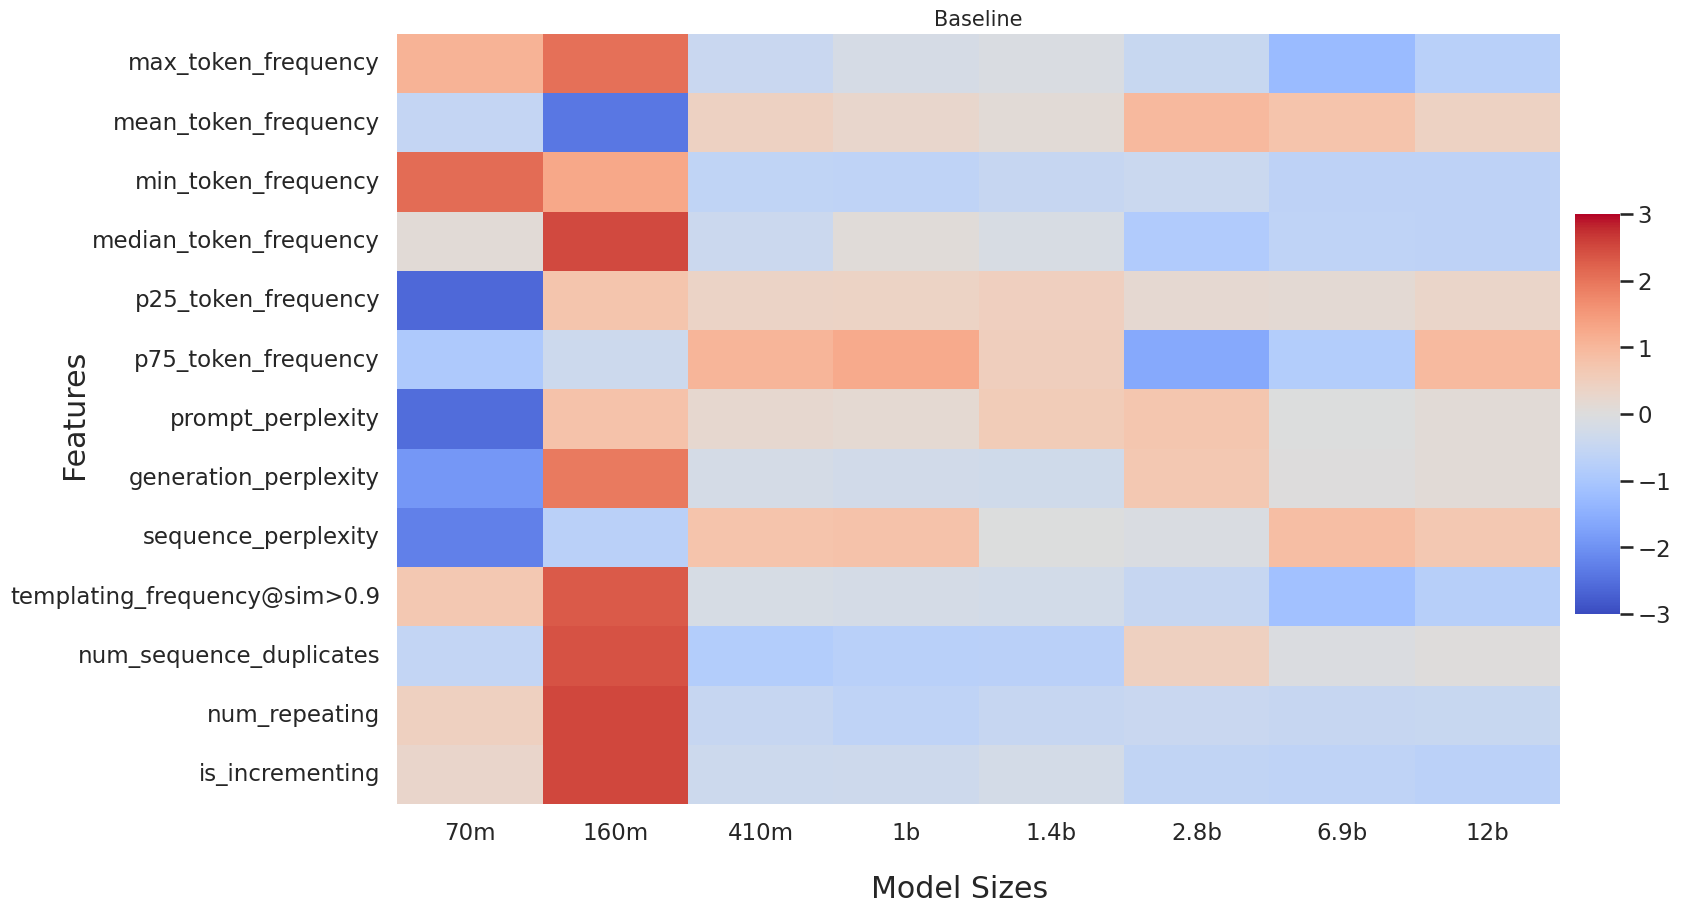

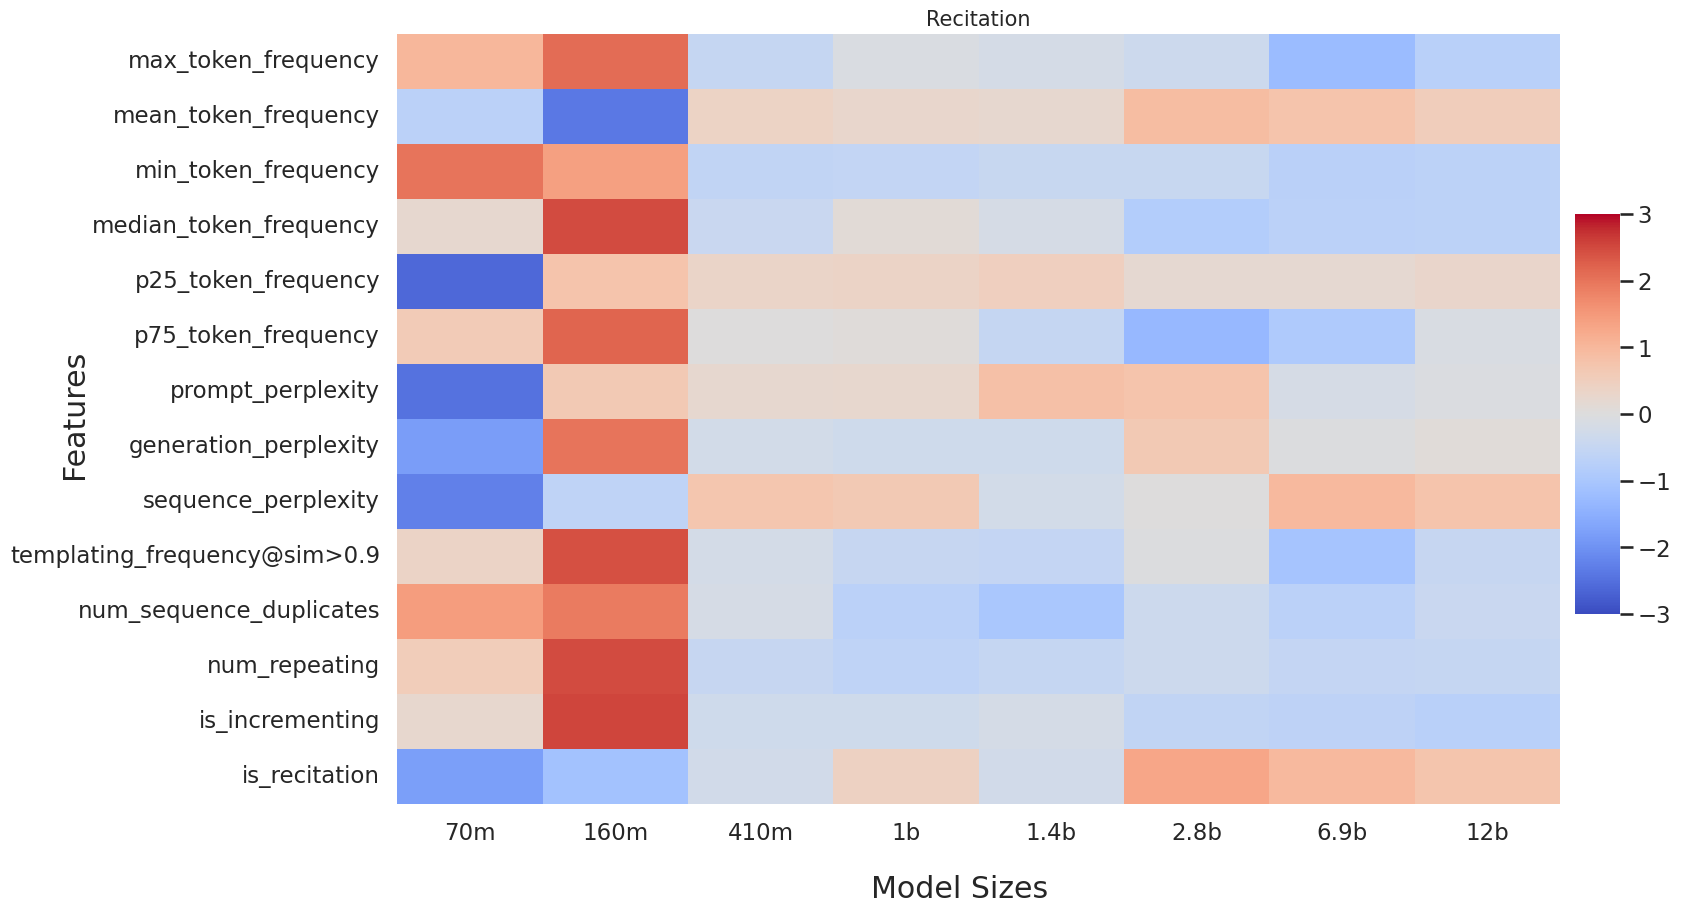

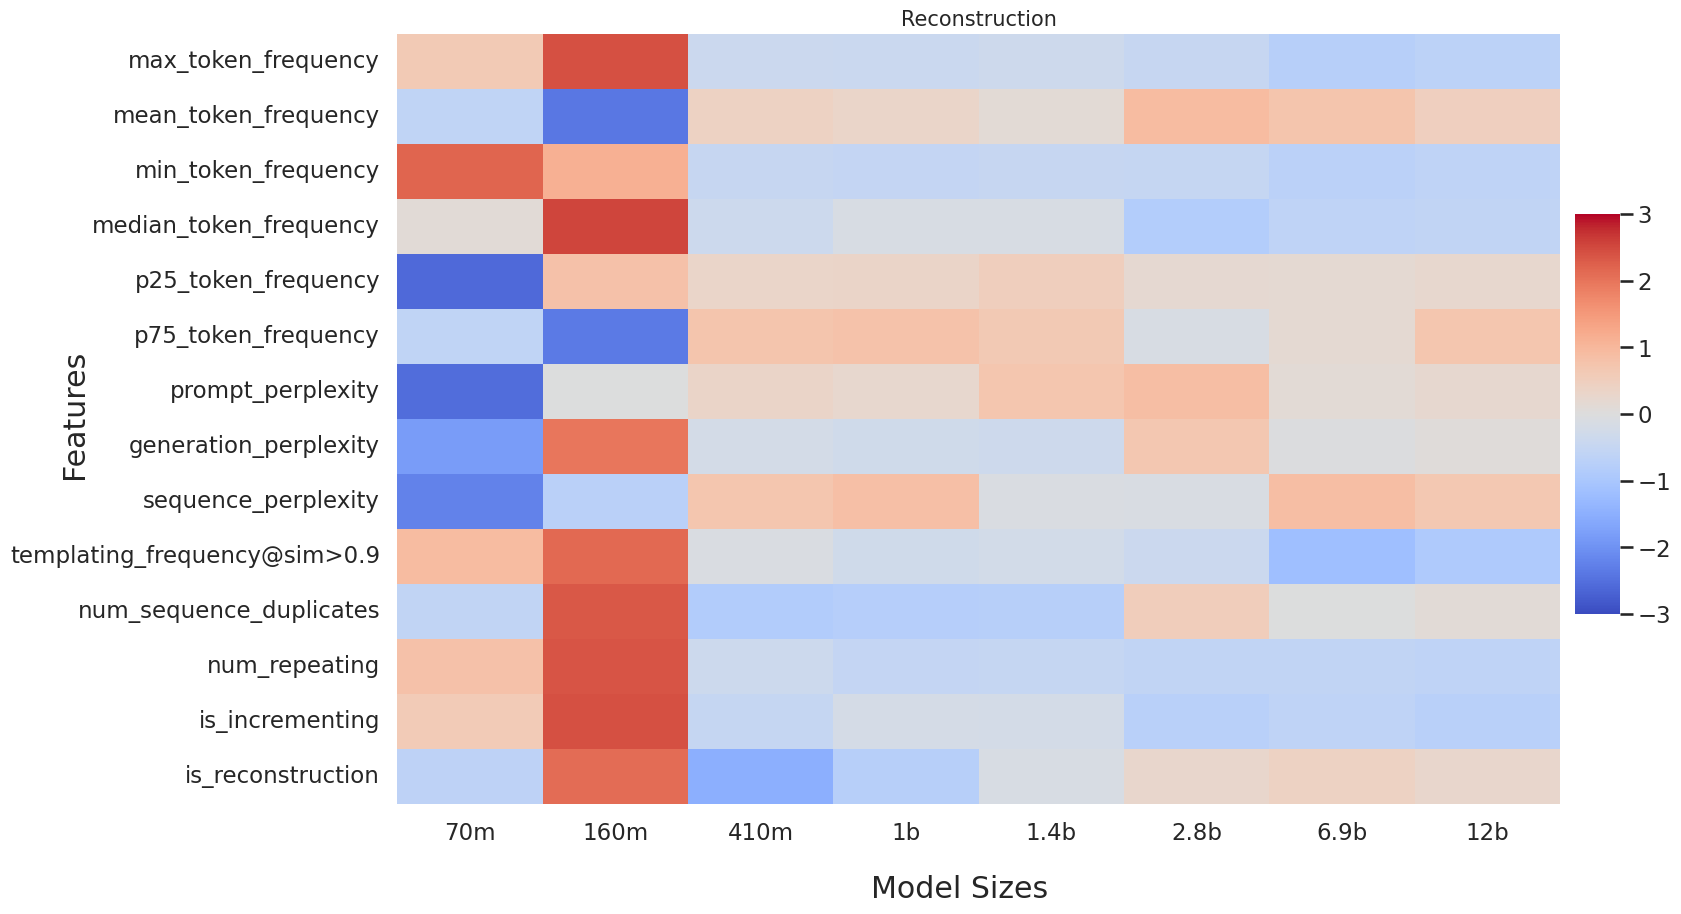

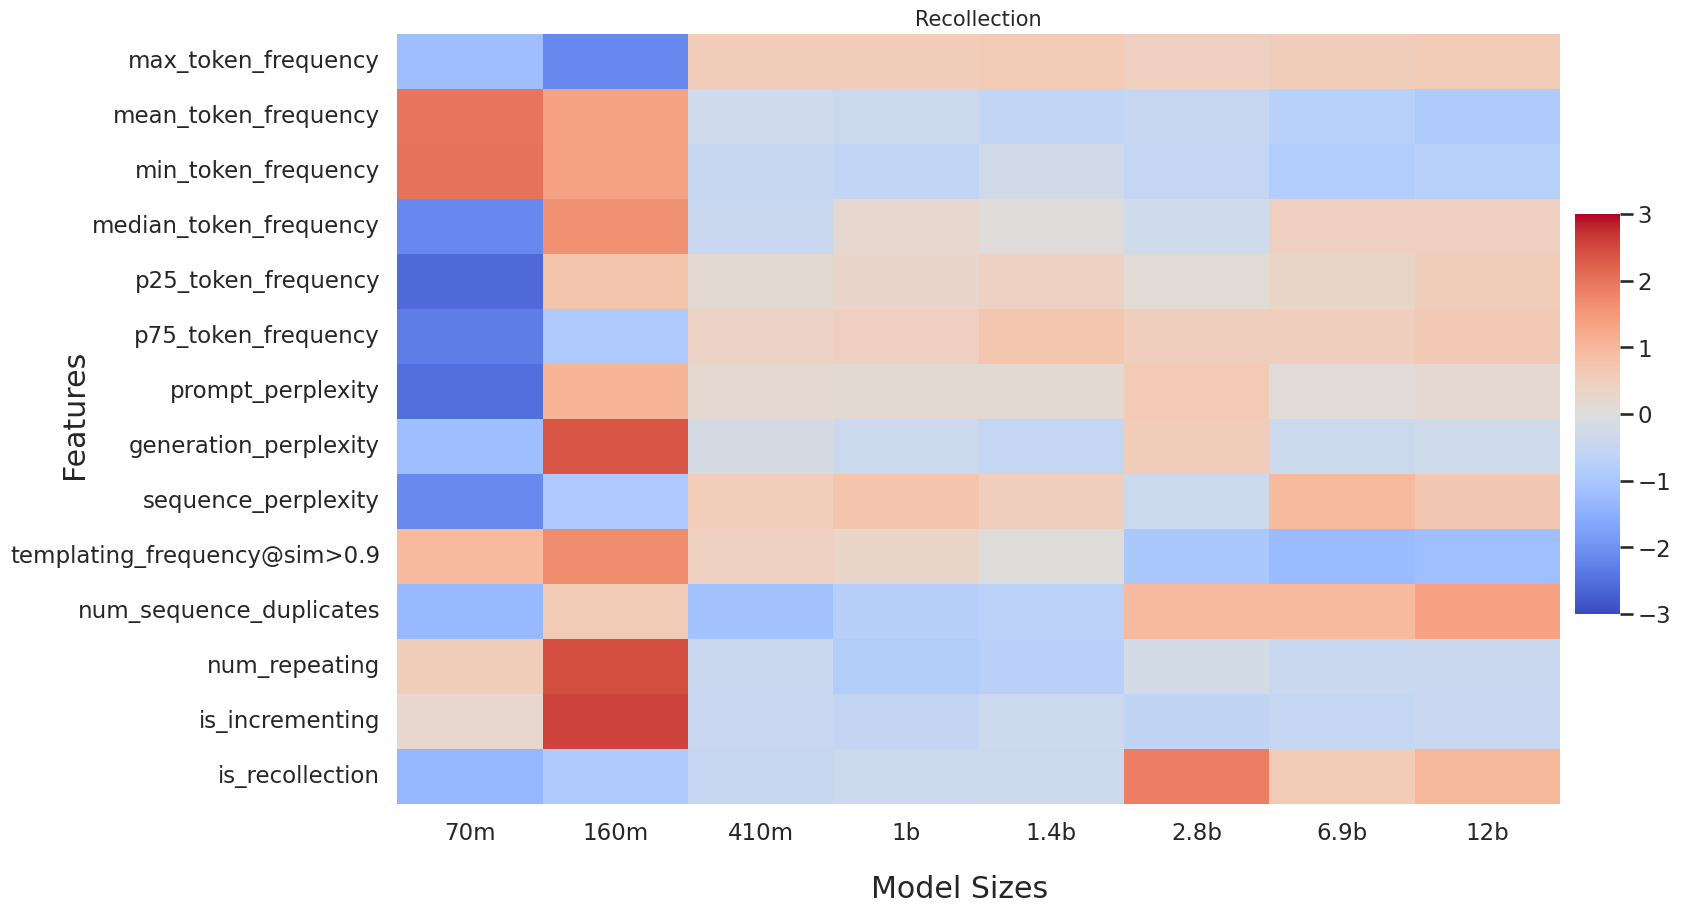

In [105]:
for taxonomy, models in lr_models.items():
    taxonomy_feature_columns = [] if taxonomy == 'baseline' else [f'is_{taxonomy}']
    scaler, weight_min, weight_max = lr_scalers[taxonomy]
    scaled_weights = scaler.transform(np.array([m[1] for m in models])).T
    
    fig_size = (15, 10)
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    ax.set_title(f'{taxonomy.capitalize()}', fontsize=15)
    fig.supxlabel('Model Sizes')
    fig.supylabel('Features', x=-0.1)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    
    sns.heatmap(
        scaled_weights,
        annot=False,
        vmin=weight_min,
        vmax=weight_max,
        cbar=True,
        cbar_ax=cbar_ax,
        cmap='coolwarm',
        xticklabels=model_sizes,
        yticklabels=renamed_feature_columns + taxonomy_feature_columns,
        ax=ax,
    )

## Model AUCs

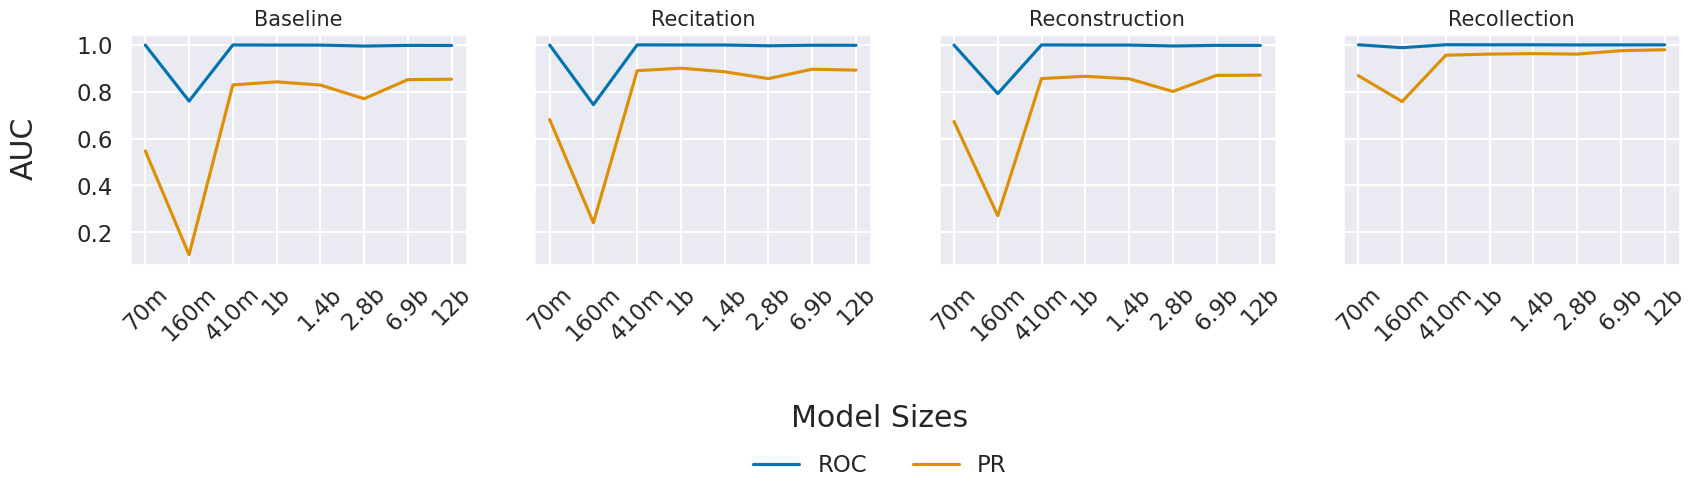

In [230]:
fig_size = (20, 3)
fig, axes = plt.subplots(1, 4, figsize=fig_size, sharey=True, sharex=True)
fig.supxlabel('Model Sizes', y=-0.45)
fig.supylabel('AUC', x=0.065)

for i, (taxonomy, models) in enumerate(lr_models.items()):
    roc_aucs = [m[2] for m in models]
    pr_aucs = [m[3] for m in models]

    sns.lineplot(roc_aucs, ax=axes[i])
    sns.lineplot(pr_aucs, ax=axes[i])
    axes[i].set_title(f'{taxonomy.capitalize()}', fontsize=15)
    axes[i].set_xticks(list(range(len(model_sizes))))
    axes[i].set_xticklabels(model_sizes, rotation=45)

handles = [axes[0].lines[0], axes[0].lines[1]]
fig.legend(handles, ['ROC', 'PR'], loc='upper center', bbox_to_anchor=(0.5, -0.45), ncol=2, bbox_transform=plt.gcf().transFigure, frameon=False)

## Conditional Tests

In [12]:
# API - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
from scipy.stats import pearsonr as pearson_correlation

# API - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
from scipy.stats import spearmanr as spearman_correlation

# Paper - https://arxiv.org/abs/1909.10140
# API - https://swarnakumar.github.io/xicorpy/xi/
from xicorpy import compute_xi_correlation as xi_correlation

In [13]:
conditional_test_outputs = defaultdict(dict)

for source_name, source in data_sources:
    for model_name in source.keys():
        tokens = model_name.split('.', 2)
        data_type, data_scheme, model_size = tokens[0], tokens[1], tokens[2]
        raw_df = source[model_name].to_pandas()
        
        # Remove invalid rows where perplexities < 0 or perplexities = inf
        filtered_df = raw_df[
            (raw_df.prompt_perplexity != -1) &
            (raw_df.generation_perplexity != -1) &
            (raw_df.sequence_perplexity != -1) &
            (raw_df.prompt_perplexity != np.inf) &
            (raw_df.generation_perplexity != np.inf) &
            (raw_df.sequence_perplexity != np.inf)
        ].reset_index(drop=True)
        
        # Scale the features to be zero-mean and unit-variance
        features = pd.DataFrame(StandardScaler().fit_transform(filtered_df[feature_columns]), columns=feature_columns)
        
        print(f'Running on {model_name}...')
        print('=' * 30)

        for taxonomy, label_column, metadata in label_metadata:
            print(f'Calculating conditional tests with {label_column}...')
            print('=' * 30)
            
            if label_column == 'sequence_duplicates':
                recitation_threshold = metadata['threshold']
                labels = (filtered_df[label_column] > recitation_threshold).astype(int)
            
            negatives = labels.value_counts().iloc[0] / len(labels)
            positives = labels.value_counts().iloc[1] / len(labels)
            print(f'Prior for {label_column} under taxonomy {taxonomy}')
            print(f'Positives: {positives * 100:.4f}% Negatives: {negatives * 100:.4f}%')
            
            pearsons = []
            spearmans = []
            xis = []
            
            for i in range(len(feature_columns)):
                specific_feature = features.iloc[:, i]
                pearson = pearson_correlation(x=specific_feature, y=labels)
                spearman = spearman_correlation(a=specific_feature, b=labels)
                xi = xi_correlation(x=specific_feature, y=labels, get_p_values=True, get_modified_xi=False)
                pearsons.append(pearson)
                spearmans.append(spearman)
                # (correlation, p-value)
                xis.append((xi[0].iloc[0].iloc[0], xi[1].iloc[0].iloc[0]))
            
            print('=' * 30)
            print()

            # Saving the model for visualizations
            if taxonomy not in conditional_test_outputs[source_name]:
                conditional_test_outputs[source_name][taxonomy] = defaultdict(list)
            conditional_test_outputs[source_name][taxonomy][label_column].append((data_type, data_scheme, model_size, pearsons, spearmans, xis))

Running on memories.deduped.1.4b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 41.6805% Negatives: 58.3195%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.023689704147287993' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4693651339110282' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4971223310730728' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/al


Running on memories.deduped.12b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 34.6369% Negatives: 65.3631%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.01910930516124365' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.38365190453657794' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4088985479245336' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/al


Running on memories.deduped.160m...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 44.0082% Negatives: 55.9918%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0417841398391241' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6012001969539092' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6012246374951571' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvi


Running on memories.deduped.1b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 42.1992% Negatives: 57.8008%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.025917322096700057' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4689026609286274' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4975244236373342' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/al


Running on memories.deduped.2.8b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 39.4728% Negatives: 60.5272%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.023366445451885043' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.42206213048005237' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.45592339730712284' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/


Running on memories.deduped.410m...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 43.0166% Negatives: 56.9834%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.03287293564924376' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.532216380656426' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5474555409764612' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvi


Running on memories.deduped.6.9b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 36.8099% Negatives: 63.1901%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.02087810301996862' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3896657119353195' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4192806353533124' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alv


Running on memories.deduped.70m...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 46.6044% Negatives: 53.3956%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.05528643641106146' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6589167888530676' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6475424647012749' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alv


Running on memories.duped.1.4b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 48.3840% Negatives: 51.6160%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.01544470215103555' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3613213224507765' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.48806278437448125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/al


Running on memories.duped.12b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 39.4873% Negatives: 60.5127%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.010961478836787664' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.31389898651521175' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.40117016552059803' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/


Running on memories.duped.160m...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 49.5679% Negatives: 50.4321%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.031636838901313635' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5126339301881306' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6132411688290891' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/al


Running on memories.duped.1b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 49.4574% Negatives: 50.5426%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.016067419513059567' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3729406766727702' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5025128513273083' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/al


Running on memories.duped.2.8b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 46.0089% Negatives: 53.9911%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.012113827143624967' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.33567653897331573' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4515794385113516' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/a


Running on memories.duped.410m...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 49.6154% Negatives: 50.3846%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.023039947241439762' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.43542654531059755' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5553187861558266' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/a


Running on memories.duped.6.9b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 42.3200% Negatives: 57.6800%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.009797528464961625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.31523852198871694' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4130559337697324' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/a


Running on memories.duped.70m...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 48.8399% Negatives: 51.1601%


/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.05035936968418053' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.618594384612031' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6687287086377973' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/alvi

/home/alvin/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5575817361267463' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi


## Conditional Test Visualizations

### Coefficients Heatmap

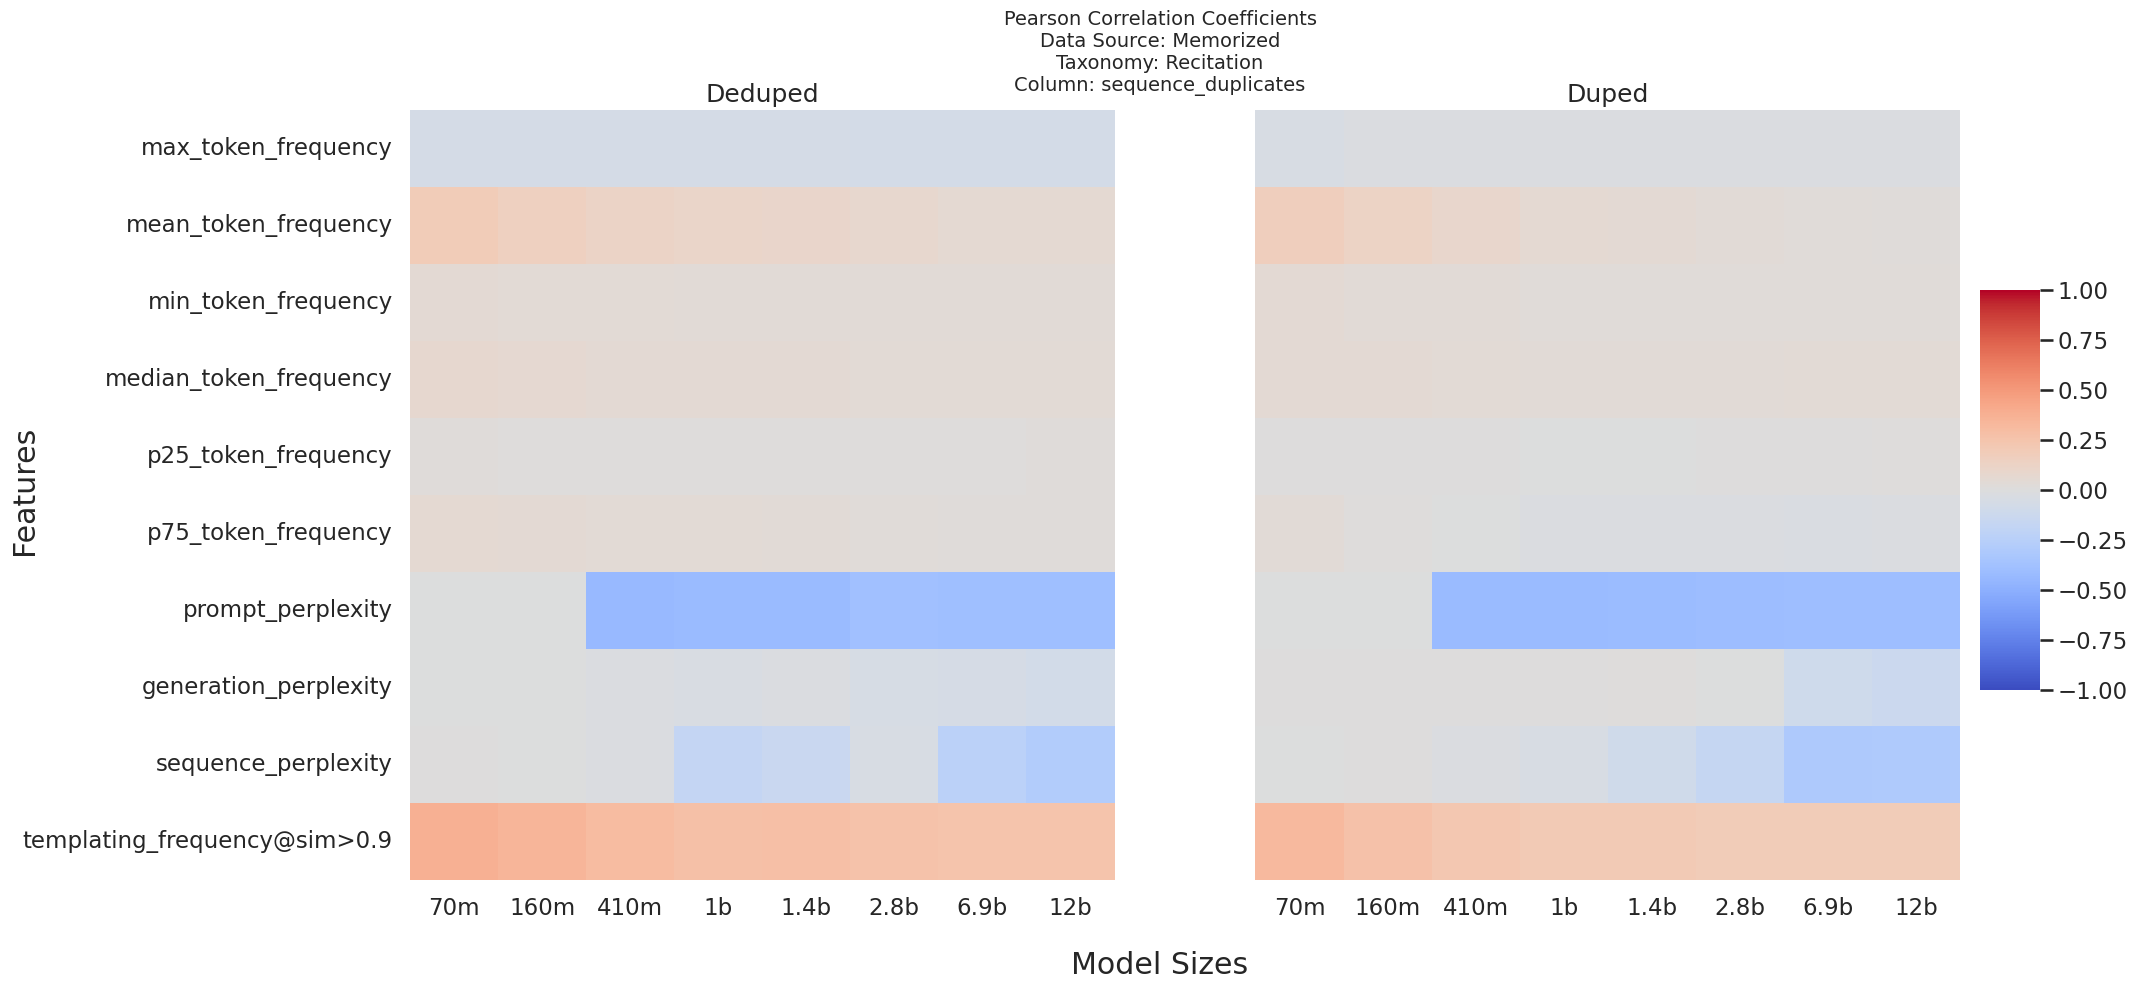

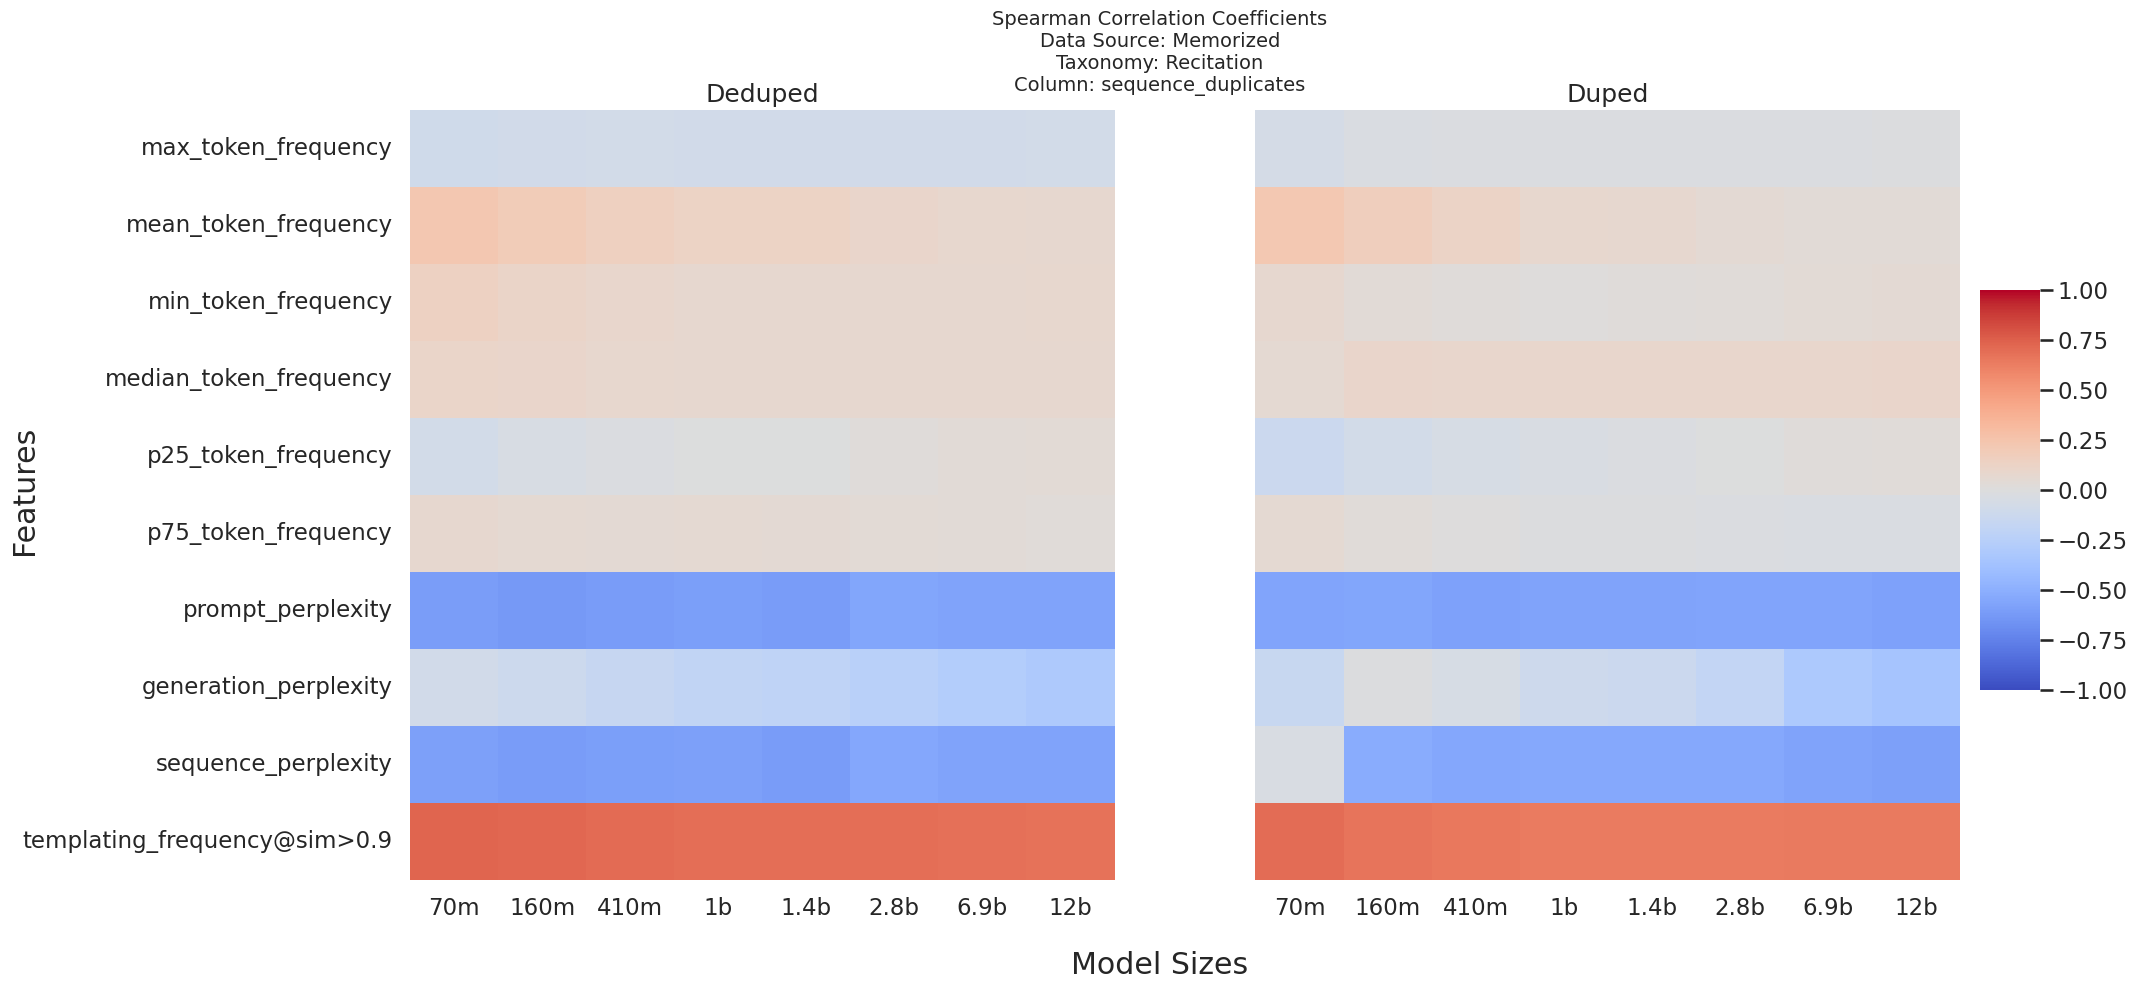

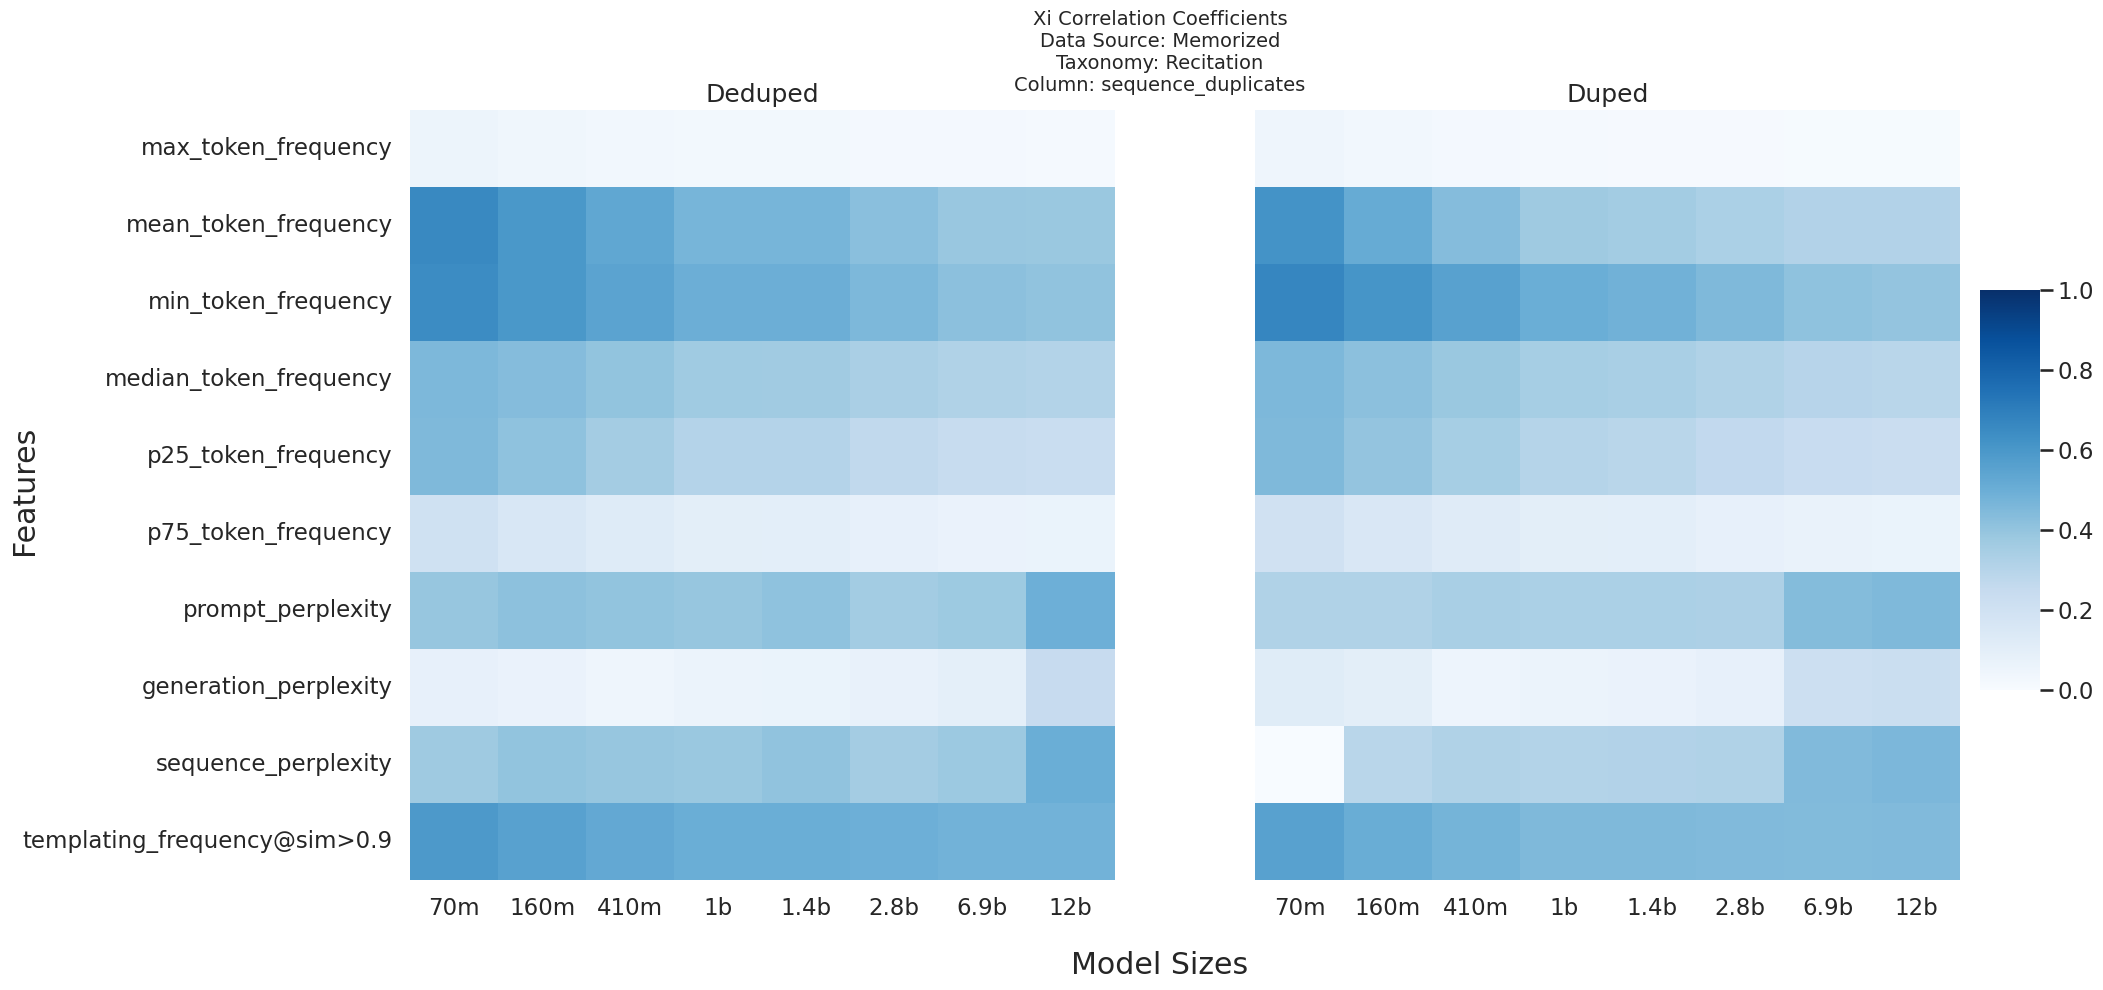

In [33]:
correlation_ranges = {
    'pearson': (-1, 1),
    'spearman': (-1, 1),
    'xi': (0, 1),
}

for source_name in conditional_test_outputs:
    for taxonomy in conditional_test_outputs[source_name]:
        for label_column in conditional_test_outputs[source_name][taxonomy]:
            cur_coefficients = defaultdict(lambda: defaultdict(list))
            # Sort the display order by the model parameter counts
            ordered_by_params = sorted(conditional_test_outputs[source_name][taxonomy][label_column], key=lambda x: (x[1], parameter_count_ordering[x[2]]))

            for data_type, data_scheme, model_size, pearsons, spearmans, xis in ordered_by_params:
                model_name = f'{data_scheme}.{model_size}'
                pearson_correlations = [p.correlation for p in pearsons]
                spearman_correlations = [s.correlation for s in spearmans]
                xi_correlations = [x[0] for x in xis]
                cur_coefficients[data_scheme]['pearson'].append((model_size, pearson_correlations))
                cur_coefficients[data_scheme]['spearman'].append((model_size, spearman_correlations))
                cur_coefficients[data_scheme]['xi'].append((model_size, xi_correlations))

            for coefficient_type in ['pearson', 'spearman', 'xi']:
                min, max = correlation_ranges[coefficient_type]
                color_theme = 'coolwarm' if coefficient_type != 'xi' else 'Blues'
                fig, axes = plt.subplots(1, len(cur_coefficients), sharex=True, sharey=True, figsize=(20, 10))
                fig.suptitle(f'{coefficient_type.capitalize()} Correlation Coefficients\nData Source: {source_name.capitalize()}\nTaxonomy: {taxonomy.capitalize()}\nColumn: {label_column}', fontsize=14)
                fig.supxlabel('Model Sizes')
                fig.supylabel('Features', x=-0.075)

                cbar_ax = fig.add_axes([.91, .3, .03, .4])

                for i, (data_scheme, coefficient_data) in enumerate(sorted(cur_coefficients.items(), key=lambda k: k[0])):
                    model_sizes = [d[0] for d in coefficient_data[coefficient_type]]
                    coefficients = np.array([d[1] for d in coefficient_data[coefficient_type]]).T
                    sns.heatmap(coefficients, annot=False, vmin=min, vmax=max, cbar=True, cmap=color_theme, cbar_ax=cbar_ax, xticklabels=model_sizes, yticklabels=renamed_feature_columns, ax=axes[i])
                    axes[i].set_title(f'{data_scheme.capitalize()}')

                plt.show()

# Saving Artifacts

In [9]:
base_directory = 'artifacts'
run_id = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = 'model.pkl'
metadata_name = 'metadata.json'

for source_name in linear_model_outputs:
    for taxonomy in linear_model_outputs[source_name]:
        for label_column in linear_model_outputs[source_name][taxonomy]:
            for data_type, data_scheme, model_size, model, roc_auc, pr_auc in tqdm(linear_model_outputs[source_name][taxonomy][label_column]):
                full_directory = f'{base_directory}/{run_id}/{data_type}/{data_scheme}/{model_size}/{taxonomy}/{label_column}'

                if not os.path.exists(full_directory):
                    os.makedirs(full_directory)

                model_path = os.path.join(full_directory, model_name)
                with open(model_path, 'wb') as file:
                    pickle.dump(model, file)

                metadata = {
                    'roc_auc': roc_auc,
                    'pr_auc': pr_auc,
                    'data_type': data_type,
                    'data_scheme': data_scheme,
                    'model_size': model_size,
                    'taxonomy': taxonomy,
                    'label_column': label_column,
                }

                metadata_path = os.path.join(full_directory, metadata_name)
                with open(metadata_path, 'w') as file:
                    json.dump(metadata, file)

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1443.82it/s]
